In [158]:
# Import dependencies
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import time as tm
import os.path
import random as rnd
import copy
import string
import matplotlib.pyplot as plt

from openpyxl import load_workbook
from openpyxl.utils.cell import range_boundaries
from grid_generator_latest import generate_grid
from collections import Counter

In [28]:
def LoadFromExcel(ExcelFile, Worksheet, Range):
    wb = load_workbook(filename=ExcelFile, read_only = True, data_only = True)
    ws = wb[Worksheet]
    dests = wb.defined_names[Range].destinations
    for title, coord in dests:
        min_col, min_row, max_col, max_row = range_boundaries(coord)
        data = ws.iter_rows(min_row, max_row, min_col, max_col, values_only = True)
    df = pd.DataFrame(data)
    return df

In [137]:
def GetData(WordFile, WordWorksheet, GridFile, GridWorksheet):
    Rank = LoadFromExcel(WordFile, WordWorksheet, 'rank')
    Frequency = LoadFromExcel(WordFile, WordWorksheet, 'frequency')
    Word = LoadFromExcel(WordFile, WordWorksheet, 'word')
    Rank.columns = ['Candidate']
    Frequency.columns = ['Candidate']
    Word.columns = ['Candidate']
    
    GridWords = LoadFromExcel(GridFile, GridWorksheet, 'NumWords')
    AcrossRef = LoadFromExcel(GridFile, GridWorksheet, 'AcrossRef')
    AcrossPos = LoadFromExcel(GridFile, GridWorksheet, 'AcrossPos')
    DownRef = LoadFromExcel(GridFile, GridWorksheet, 'DownRef')
    DownPos = LoadFromExcel(GridFile, GridWorksheet, 'DownPos')
    
    return Rank, Frequency, Word, GridWords, AcrossRef, AcrossPos, DownRef, DownPos

In [143]:
Lexicon = 'large.xlsx'   # large.xlsx
Grid = 'grid-7-2.xlsx'

WordWorksheet = 'Data'
GridWorksheet = 'Grid'
WordFile = os.path.join(os.getcwd() + '\lexicon', Lexicon)
GridFile = os.path.join(os.getcwd() + '\grid', Grid)

Rank, Frequency, Word, GridWords, AcrossRef, AcrossPos, DownRef, DownPos = GetData(WordFile, WordWorksheet, GridFile, GridWorksheet)

In [144]:
with open("large_lexicon.txt", 'w') as f:
    f.write("\n".join(Word['Candidate'].tolist()))

In [117]:
def find_indices(lst, element):
    indices = []
    start_index = None

    for i, value in enumerate(lst):
        if value == element:
            if start_index is None:
                start_index = i
        elif start_index is not None:
            indices.append((start_index, i - 1))
            start_index = None

    if start_index is not None:
        indices.append((start_index, len(lst) - 1))

    return indices

def get_grid_data_MILP(size = 7, display_grid = False):
    json_data = generate_grid(grid_size = size, b_factor = 6, display_grid = display_grid)
    rows, cols = json_data['size']['rows'], json_data['size']['cols']
    grid_2d = ['|'.join(json_data['grid'][i:i+cols]).replace('.', '0').split('|') for i in range(0, len(json_data['grid']), rows)]
    grid_2d = [[0 if col == '0' else -1 for col in row] for row in grid_2d]
    
    across_ref_ = copy.deepcopy(grid_2d)
    across_pos_ = copy.deepcopy(grid_2d)
    down_ref_ = copy.deepcopy(grid_2d)
    down_pos_ = copy.deepcopy(grid_2d)

    ref_count = 1
    pos_count = 1
    for i, row in enumerate(grid_2d):
        indices = find_indices(row, -1)
        for index_tuple in indices:
            pos_count = 1
            for j in range(index_tuple[0], index_tuple[1] + 1):
                across_ref_[i][j] = ref_count
                across_pos_[i][j] = pos_count
                pos_count += 1
            ref_count += 1

    for i in range(len(grid_2d)):
        for j in range(len(grid_2d[0])):
            if down_ref_[i][j] == -1:
                pos_count = 1
                for k in range(i, len(grid_2d)):
                    if down_ref_[k][j] != 0:
                        down_ref_[k][j] = ref_count
                        down_pos_[k][j] = pos_count
                        pos_count += 1
                    elif down_ref_[k][j] == 0:
                        break
                ref_count += 1

    return pd.DataFrame(across_ref_), pd.DataFrame(across_pos_), pd.DataFrame(down_ref_), pd.DataFrame(down_pos_), pd.DataFrame([ref_count-1])

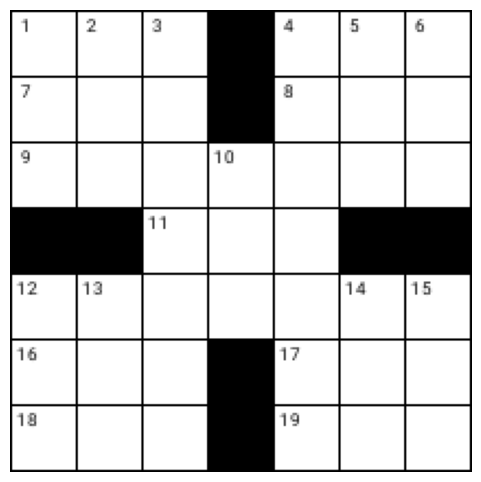

,0
0,22


In [118]:
AcrossRef, AcrossPos, DownRef, DownPos, GridWords = get_grid_data_MILP(display_grid = True)

In [145]:
def get_word_file_MILP(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        words = file.read().split()

    translator = str.maketrans('', '', string.punctuation)
    cleaned_words = [word.translate(translator).lower() for word in words]

    char_frequencies = Counter(''.join(cleaned_words))

    def word_score(word):
        return sum(char_frequencies[char] for char in word) / len(word)

    word_scores = {word: word_score(word) for word in cleaned_words}

    frequency_list = []
    word_list = []
    for word, score in sorted(word_scores.items(), key=lambda x: x[1], reverse=True):
        word_list.append(word)
        frequency_list.append(score)

    Rank = pd.DataFrame(range(1, len(word_list) + 1), columns = ['Candidate'])
    Word = pd.DataFrame(word_list, columns = ['Candidate'])
    Frequency = pd.DataFrame(frequency_list, columns = ['Candidate'])
    return Rank, Word, Frequency

### Lets the Gutenberg Lexicon and the Large Lexicon used by them

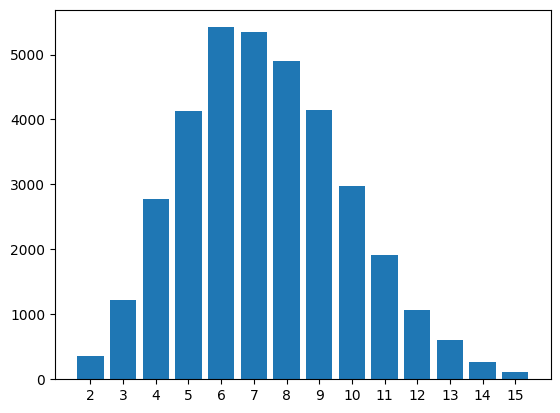

In [165]:
gutenberg_answers = open("gutenberg_lexicon.txt").read().splitlines()
answer_len_dict = {}
for answer in gutenberg_answers:
    if len(answer) in answer_len_dict.keys():
        answer_len_dict[len(answer)] += 1
    else:
        answer_len_dict[len(answer)] = 0
        
len_count_list = []
for ans_len, count in answer_len_dict.items():
    len_count_list.append([ans_len, count])
    
len_count_list.sort(key = lambda x: x[0])
len_count = np.array(len_count_list)

plt.bar(len_count[:, 0], len_count[:, 1])
plt.xticks(len_count[:, 0])
plt.show()